<a href="https://colab.research.google.com/github/DanielaSchacherer/IDC-Tutorials/blob/dicom_web_access_tutorial/idc_dcmweb_access.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IDC DICOMweb data access for pathology whole-slide images

This notebook accompanies the documentation article [IDC DICOMweb data access
](tbd) for the NCI Imaging Data Commons, which describes how one can access IDC pathology data using DICOMweb.

This notebook solely replicates the content of the code cells from the documentation article above for convenience. Please read the actual article for details!

Questions? Ask those at the IDC forum here: https://discourse.canceridc.dev.

-----
Created: Juli 2025

In [1]:
%%capture
!pip install wsidicom
!pip install ez-wsi-dicomweb

## wsidicom

In [2]:
from dicomweb_client.api import DICOMwebClient
from dicomweb_client.ext.gcp.session_utils import create_session_from_gcp_credentials

###If accessing Google-maintained DICOM store run the following cell

In [7]:
# If accessing the Google-maintained DICOM store, you need to authenticate with your Google credentials first
from google.colab import auth
auth.authenticate_user()

# Create session and build path to DICOM store
session = create_session_from_gcp_credentials()

# Set-up a DICOMwebClient using the dicomweb_client library
google_dicom_store_url = 'https://healthcare.googleapis.com/v1/projects/nci-idc-data/locations/us-central1/datasets/idc/dicomStores/idc-store-v20/dicomWeb'
dw_client = DICOMwebClient(
    url=google_dicom_store_url,
    session = session
)

###If accessing IDC-maintained DICOM store run the following cell

In [3]:
# Set-up a DICOMwebClient using the dicomweb_client library
idc_dicom_store_url = 'https://proxy.imaging.datacommons.cancer.gov/current/viewer-only-no-downloads-see-tinyurl-dot-com-slash-3j3d9jyp/dicomWeb'
dw_client = DICOMwebClient(url=idc_dicom_store_url)

### Access

In [4]:
import wsidicom
import matplotlib.pyplot as plt

In [8]:
# Wrap into wsidicom client
wsidicom_client = wsidicom.WsiDicomWebClient(dw_client)

# Open the slide via DICOMweb interface of wsidicom
slide = wsidicom.WsiDicom.open_web(wsidicom_client,
    study_uid='2.25.317753984268209060558780446660059290395',
    series_uids='1.3.6.1.4.1.5962.99.1.1042652702.25371455.1637425225246.2.0'
)
# Investigate existing levels and their dimensions
print(slide)

WsiDicom of pyramids:
[0]: Pyramid of levels:
      [0]: Level: 0, size: Size(width=46336, height=44288) px, mpp: SizeMm(width=0.2325, height=0.2325) um/px Instances:         [0]: default z: 0.0 default path: 1 ImageData <wsidicom.web.wsidicom_web_image_data.WsiDicomWebImageData object at 0x7da138153dd0>
      [1]: Level: 2, size: Size(width=11584, height=11072) px, mpp: SizeMm(width=0.93, height=0.93) um/px Instances:         [0]: default z: 0.0 default path: 1 ImageData <wsidicom.web.wsidicom_web_image_data.WsiDicomWebImageData object at 0x7da138547c90>
      [2]: Level: 4, size: Size(width=2896, height=2768) px, mpp: SizeMm(width=3.72, height=3.72) um/px Instances:         [0]: default z: 0.0 default path: 1 ImageData <wsidicom.web.wsidicom_web_image_data.WsiDicomWebImageData object at 0x7da138bd3710>


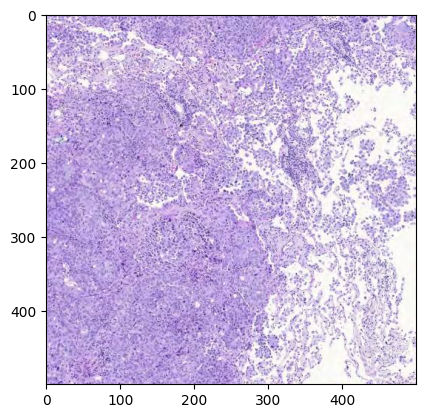

In [9]:
# Access and visualize 500x500px subregion at level 4, starting from pixel (1000,1000)
region = slide.read_region(location=(1000, 1000), level=4, size=(500, 500))
plt.imshow(region)
plt.show()

## ez-wsi-dicomweb

In [10]:
from ez_wsi_dicomweb import dicomweb_credential_factory
from ez_wsi_dicomweb import dicom_slide
from ez_wsi_dicomweb import local_dicom_slide_cache_types
from ez_wsi_dicomweb import dicom_web_interface
from ez_wsi_dicomweb import patch_generator
from ez_wsi_dicomweb import pixel_spacing
from ez_wsi_dicomweb.ml_toolkit import dicom_path

In [11]:
from google.colab import auth
auth.authenticate_user()

google_dicom_store_url = 'https://healthcare.googleapis.com/v1/projects/nci-idc-data/locations/us-central1/datasets/idc/dicomStores/idc-store-v20/dicomWeb'
study_uid = '2.25.317753984268209060558780446660059290395'
series_uid = '1.3.6.1.4.1.5962.99.1.1042652702.25371455.1637425225246.2.0'

series_path_str = (
      f'{google_dicom_store_url}'
      f'/studies/{study_uid}'
      f'/series/{series_uid}'
)
series_path = dicom_path.FromString(series_path_str)
dcf = dicomweb_credential_factory.CredentialFactory()
dwi = dicom_web_interface.DicomWebInterface(dcf)

ds = dicom_slide.DicomSlide(
    dwi=dwi,
    path=series_path,
    enable_client_slide_frame_decompression = True
    )

# Enable slide frame cache. More information: https://github.com/GoogleCloudPlatform/EZ-WSI-DICOMweb/blob/main/ez_wsi_demo.ipynb
ds.init_slide_frame_cache(
    optimization_hint=local_dicom_slide_cache_types.CacheConfigOptimizationHint.MINIMIZE_LATENCY
    )

In [12]:
# Investigate existing levels and their dimensions
for level in ds.levels:
    print(f'Level {level.level_index} has pixel dimensions (row, col): {level.height, level.width}')

Level 1 has pixel dimensions (row, col): (44288, 46336)
Level 2 has pixel dimensions (row, col): (11072, 11584)
Level 3 has pixel dimensions (row, col): (2768, 2896)


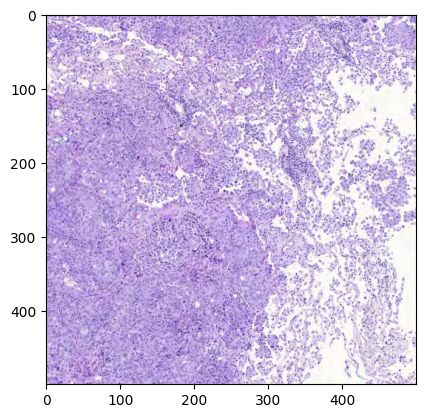

In [13]:
# Access and visualize 500x500px subregion at level 3, starting from pixel (1000,1000)

level = ds.get_level_by_index(3)
region = ds.get_patch(level=level, x=1000, y=1000, width=500, height=500).image_bytes()
plt.imshow(region)
plt.show()